Comparing 33 Warps from HSC-I SSP_UDEEP_COSMOS patch 7,6, with goal of exploring the types of artifacts and astrophysical objects that appear in the differences.


We have two categories of detections in the warp differences: Transient detections we want to mask and poor subtraction artifacts. We can't mask all positive detections in the warp differences because the subtractions are not perfect and don't want to masking true variable sources. One feature we can use is that if a source subtracts poorly in one image it subtracts poorly in many images. The idea is to use a configurable cutoff in units of # of images. I propose 3. For any given warp, if the positive detection (configurably 5 sigma) overlaps a pixel with <= 3 positive diff counts, its transient: mask it. If it appears in >3 warps, its a source that is difficult to PSF-match and subtract, and should not be masked.

Ambiguous cases: We want to error on the side of masking too much.  In this example of the asteroid moving accross the saturated star, we want to mask it.

Questions:
1. Should we clip positive and negative detections in the differences or just postitive? On one hand we only expect artifacts to be positive. However, if we only clip abnormally high pixels, any mistakes would bias our coadds.


In [1]:
import numpy as np
import os
import lsst.afw.image as afwImage
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom

%matplotlib inline

/tigress/HSC/LSST/stack_20160915/Linux64/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


The following 33 image differences were generated as follows:

1.  __Generate median PSF-Matched coadd__ Matched to a DoubleGaussian w/ fwhm of 7 pixels. 
2.  __Diff = Warp - Median Coadd__
    
        Visit information:
        ALL: U-03-010001 HSC-I SSP_UDEEP_COSMOS
        1228	150.1104208	2.201652778	270	0.85364266	0.965629	3/28/14
        1230	150.1521292	2.160005556	270	0.86945261	0.959954	3/28/14
        1232	150.1938333	2.222472222	270	0.83653479	0.964513	3/28/14
        1238	150.127125	2.20995	270	0.76726676	1.0021	3/28/14
        1240	150.1688042	2.168322222	270	0.88539269	1.00218	3/28/14
        1242	150.2105042	2.230811111	270	0.83828394	0.99828	3/28/14
        1244	150.0854208	2.251622222	270	0.79821742	0.989406	3/28/14
        1246	150.0437083	2.189136111	270	0.78169936	1.00735	3/28/14
        1248	150.0687375	2.243311111	270	0.83069584	0.997942	3/28/14
        19658	150.1187542	2.20585	300	0.54768675	1.06164	1/21/15
        19660	150.1604542	2.164183333	300	0.60257457	1.06578	1/21/15
        19662	150.2021583	2.226661111	300	0.54025075	1.06682	1/21/15
        19680	150.0770625	2.247505556	300	0.5334654	1.06188	1/21/15
        19682	150.0353667	2.185013889	300	0.50978512	1.07004	1/21/15
        19684	150.2074208	2.176972222	300	0.53421238	1.06806	1/21/15
        19694	150.2491292	2.135283333	300	0.59834112	1.07035	1/21/15
        19696	150.290825	2.197811111	300	0.58604637	1.05552	1/21/15
        19698	150.1657458	2.218616667	300	0.70953974	1.02685	1/21/15
        19708	150.12405	2.156122222	300	1.11109388	0.936344	1/21/15
        19710	150.0715042	2.313080556	300	1.04386906	0.971211	1/21/15
        19712	150.1131875	2.271419444	300	0.97174324	0.990672	1/21/15
        30482	150.1549083	2.333888889	300	0.78258999	1.02168	5/21/15
        30484	150.0298	2.354744444	300	0.80335164	1.02104	5/21/15
        30486	149.9881167	2.292247222	300	0.73915699	1.04273	5/21/15
        30488	150.0081333	2.178627778	300	0.65142233	1.04633	5/21/15
        30490	150.0498208	2.13695	300	0.57450367	1.06437	5/21/15
        30492	150.0915083	2.199458333	300	0.66824797	1.04158	5/21/15
        30494	149.9664083	2.220294444	300	0.62858367	1.04537	5/21/15
        30496	149.9247375	2.157794444	300	0.63382774	1.03902	5/21/15
        30498	150.2232875	2.238361111	300	0.63693565	1.03903	5/21/15
        30500	150.2649875	2.196655556	300	0.57763524	1.05852	5/21/15
        30502	150.306675	2.259177778	300	0.55134729	1.04203	5/21/15
        30504	150.1815667	2.280036111	300	0.68257748	1.03591	5/21/15

In [2]:
expDict = {}

DIR = "/tigress/HSC/HSC/rerun/alsayyad/warp_compare/MEDIAN"
for filename in sorted(os.listdir(DIR)):
    visit = filename.replace('.fits', '')
    try:
        visitNum = int(visit)
    except Exception as e:
        print "Skipping %s" % (visit)
        continue
    expDict[visit] = afwImage.ExposureF(os.path.join(DIR, filename))

imList = []
keyList = []
varList = []
for key, exp in expDict.iteritems():
    keyList.append(key)
    imList.append(exp.getMaskedImage().getImage().getArray())
    varList.append(exp.getMaskedImage().getVariance().getArray())

Skipping psfMatched-7,6


In [3]:
def plot(arr, title, cmap=None):
    plt.figure(figsize=(11,10))
    vmin = np.percentile(arr[np.where(np.isfinite(arr))], 1)
    vmax = np.percentile(arr[np.where(np.isfinite(arr))], 99)
    plt.imshow(arr, vmin=vmin, vmax=vmax,  origin='lower', cmap=cmap, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.show()

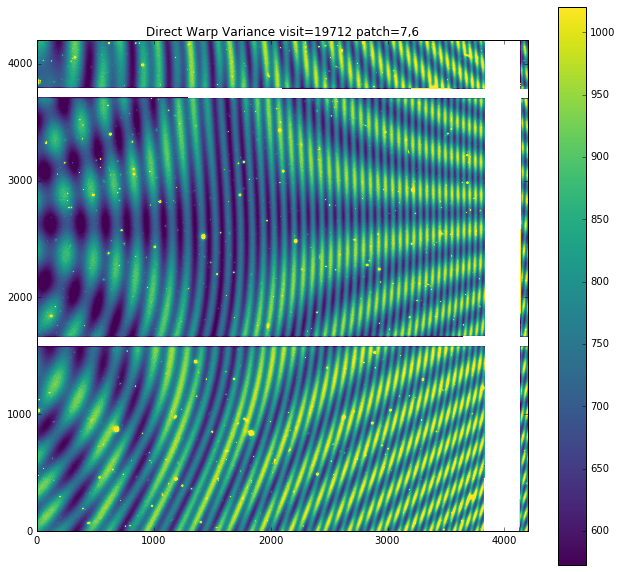

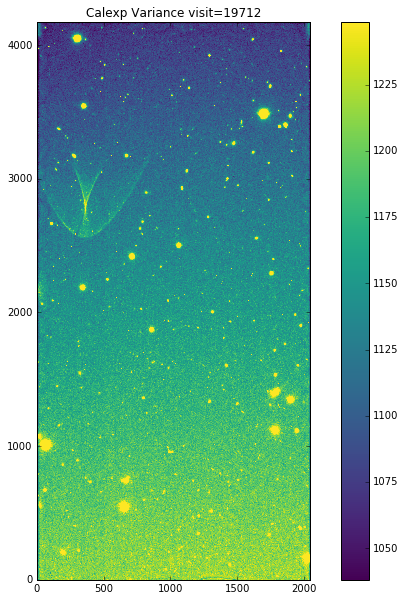

In [11]:
# Aside: The variance in warps are pretty wild looking

# Variance
butlerCoadd = dafPersist.Butler('/tigress/HSC/HSC/rerun/alsayyad/cosmos_test_artifact_reject')
warp = butlerCoadd.get("deepCoadd_directWarp", patch='7,6', tract=0, filter='HSC-I', visit=19712)
plot(warp.getMaskedImage().getVariance().getArray(),
     'Direct Warp Variance visit=%s patch=7,6' % (19712),
     'viridis')



butler = dafPersist.Butler('/tigress/HSC/HSC/rerun/alsayyad/calexp_dir/')
calexp = butler.get("calexp", visit=19712, ccd=52)
background = butler.get("calexpBackground", immediate=True, visit=19712, ccd=52)
plot(calexp.getMaskedImage().getVariance().getArray(),
     'Calexp Variance visit=%s' % (19712),
     'viridis')

In [12]:
cube = np.array(imList)
cubeVar = np.array(varList)
cubeSNR = cube/np.sqrt(cubeVar)

In [5]:
imMean = np.nanmean(cube, axis=0)
imMedian = np.nanmedian(cube, axis=0)
snrSum = np.nansum(cubeSNR, axis=0)
snrMean = np.nanmean(cubeSNR, axis=0)
snrMedian = np.nanmedian(cubeSNR, axis=0)

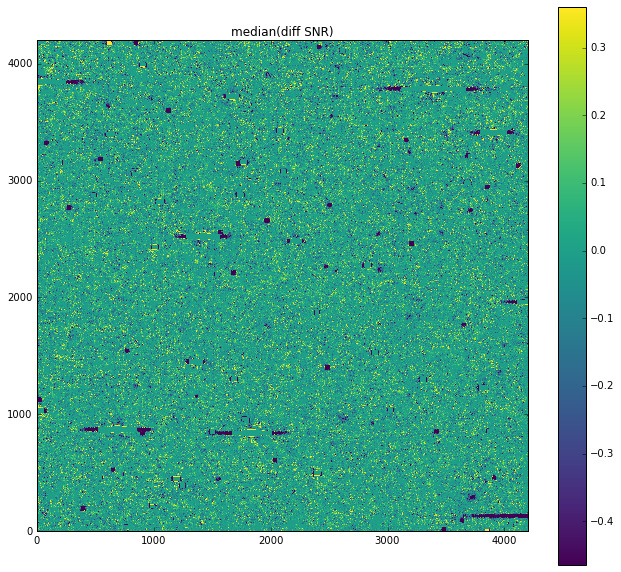

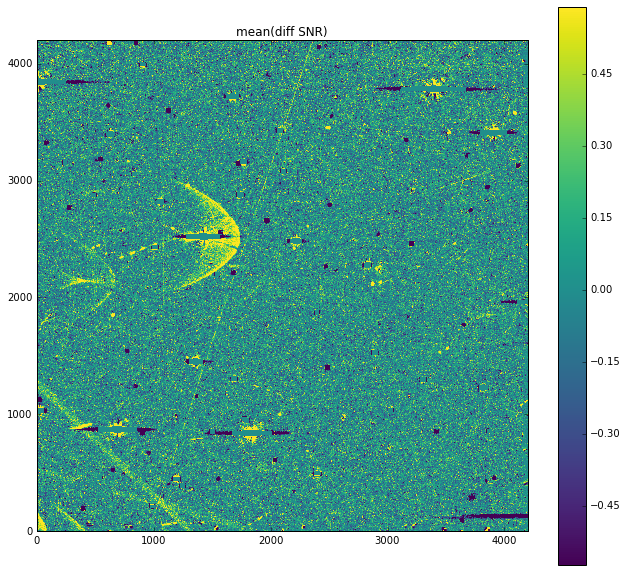

In [6]:
plot(snrMedian, 'median(diff SNR)', 'viridis')
plot(snrMean, 'mean(diff SNR)', 'viridis')

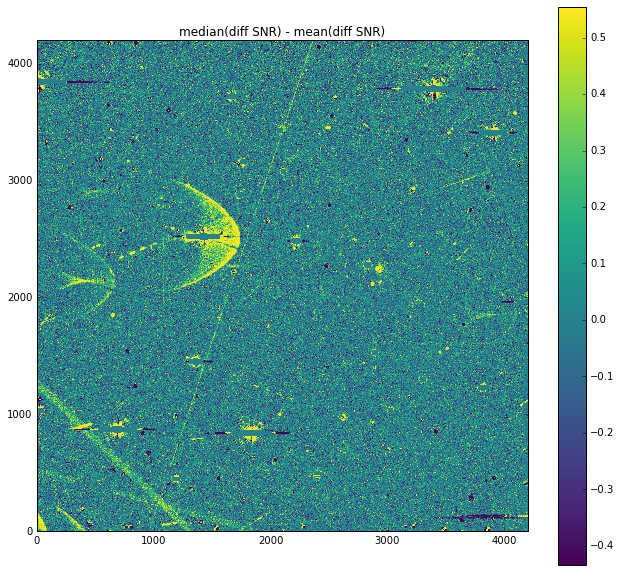

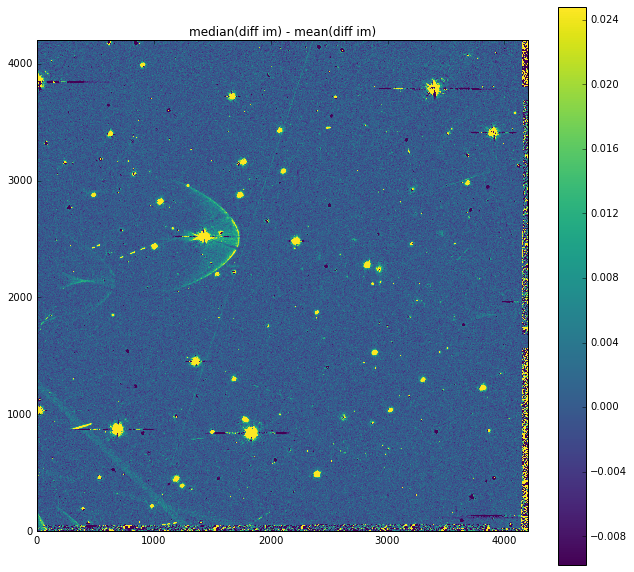

In [7]:
plot(snrMean - snrMedian, 'median(diff SNR) - mean(diff SNR)', 'viridis')
plot(imMean - imMedian, 'median(diff im) - mean(diff im)', 'viridis')

# TIME 

## Counting the number of epochs a pixel is a detection in the difference

The following plots show the number of epochs a pixels inteh warp differences are > 5 sigma. More precisely, how many times do the pixels have SNR > 5 or < -5, where SNR is the image plane divided by the inverse sqrt of the variance plane. 

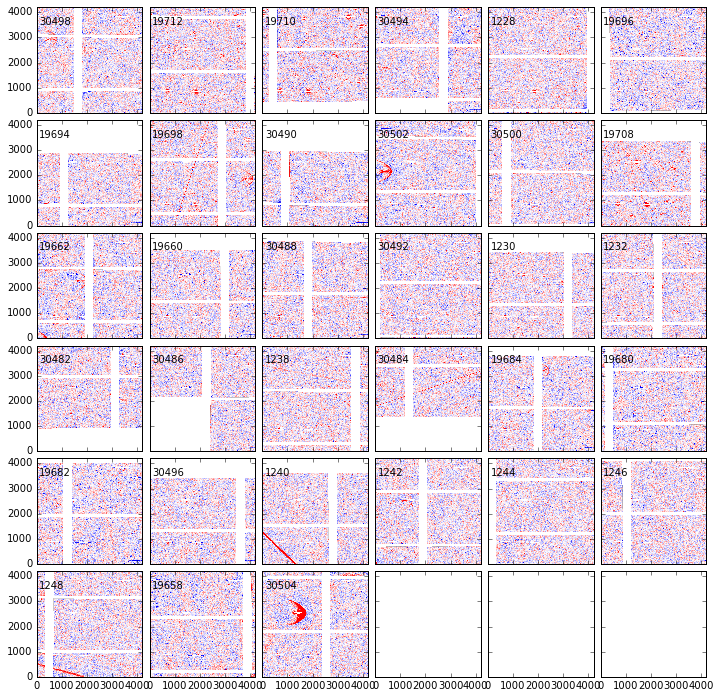

In [9]:
N = len(cubeSNR)
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


fig = plt.figure(1, (12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(int(np.sqrt(N)+1), int(np.sqrt(N)+1)),
                 axes_pad=0.1, 
                 )

for i in range(len(cubeSNR)):
    grid[i].text(100,3500, keyList[i])
    grid[i].imshow(cubeSNR[i], vmin=-5, vmax=5,  origin='lower', cmap='bwr')



In [10]:
count = np.copy(cubeSNR)
count[np.where((cubeSNR < 5) & (cubeSNR > -5))] = 0
count[np.where((cubeSNR > 5) | (cubeSNR < -5))] = 1
sum_count = np.nansum(count, axis=0)

count_pos = np.copy(cubeSNR)
count_pos[np.where(cubeSNR < 5)] = 0
count_pos[np.where(cubeSNR > 5)] = 1
sum_count_pos = np.nansum(count_pos, axis=0)


/tigress/HSC/LSST/stack_20160915/Linux64/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/tigress/HSC/LSST/stack_20160915/Linux64/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/tigress/HSC/LSST/stack_20160915/Linux64/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/tigress/HSC/LSST/stack_20160915/Linux64/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/tigress/HSC/LSST/stack_20160915/Linux64/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less
/tigress/HSC/LSS

/tigress/HSC/LSST/stack_20160915/Linux64/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/tigress/HSC/LSST/stack_20160915/Linux64/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


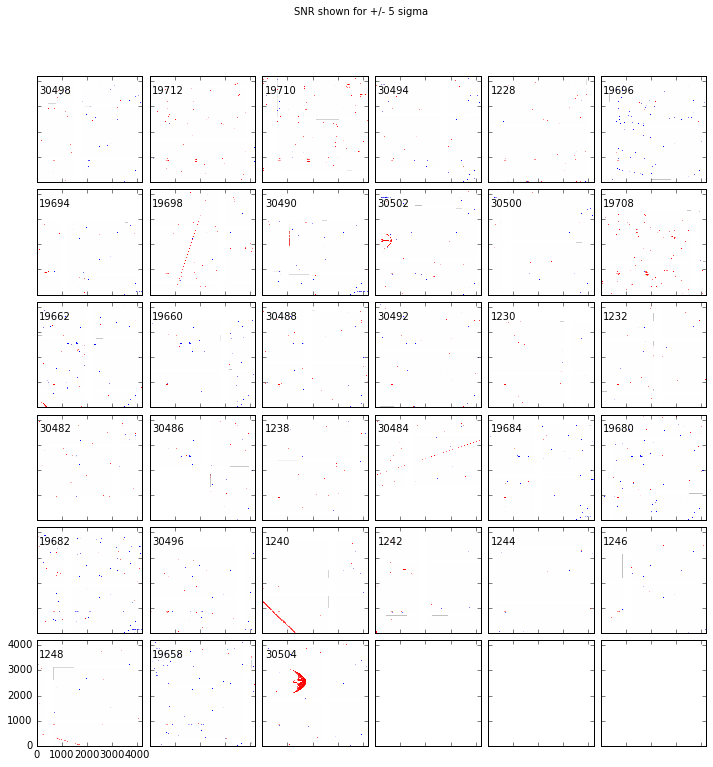

In [13]:
snr = np.copy(cubeSNR)
snr[np.where((snr < 5) & (snr > -5))] = 0

N = len(snr)
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


fig = plt.figure(1, (12., 12.))
fig.suptitle("SNR shown for +/- 5 sigma")
grid = ImageGrid(fig, 111,
                 nrows_ncols=(int(np.sqrt(N)+1), int(np.sqrt(N)+1)), 
                 axes_pad=0.1,
                 label_mode='1'
                 )

for i in range(N):
    grid[i].text(100,3500, keyList[i])
    grid[i].imshow(snr[i], vmin=-10, vmax=10,  origin='lower', cmap='bwr')

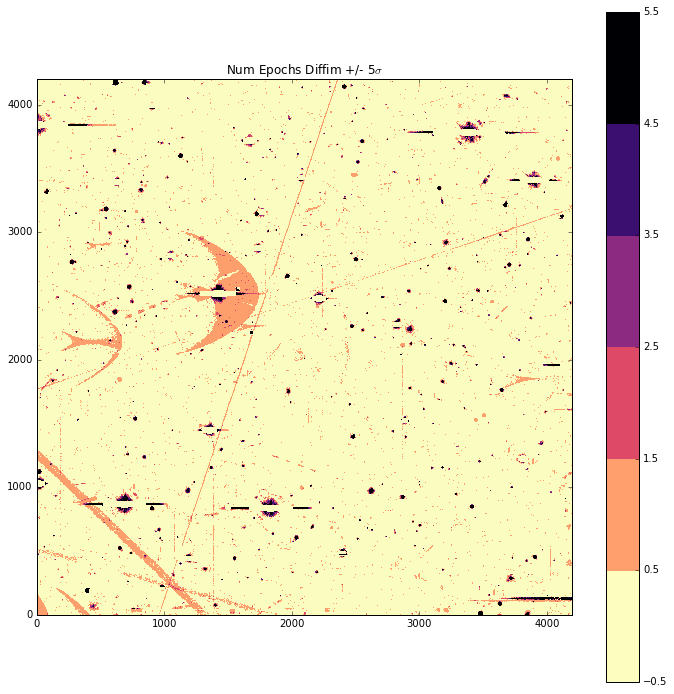

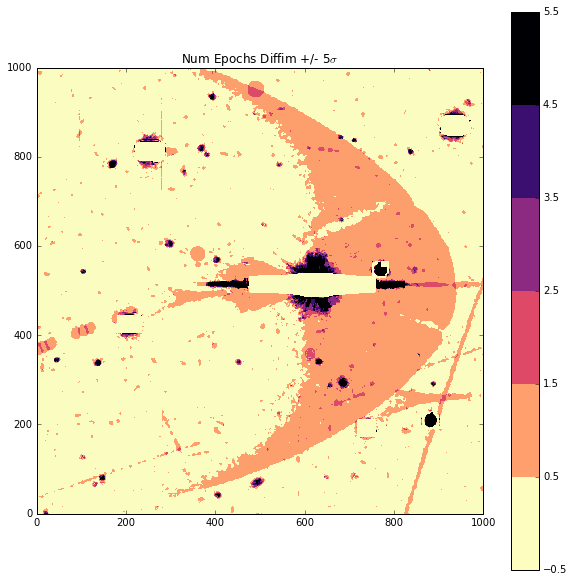

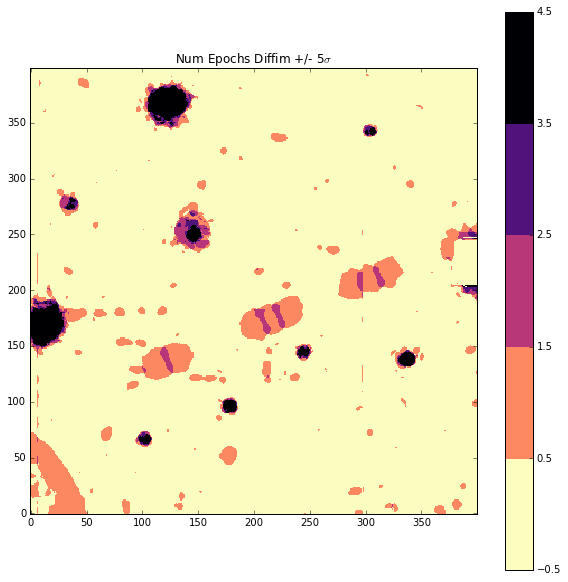

In [14]:

import matplotlib
plt.figure(figsize=(12,12))
cmap=plt.cm.magma_r
plt.title("Num Epochs Diffim +/- 5$\sigma$")
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,6.5,1), cmap.N)
plt.imshow(sum_count, norm=norm , origin='lower', cmap=cmap, interpolation='nearest')
plt.colorbar()

plt.figure(figsize=(10,10))
plt.title("Num Epochs Diffim +/- 5$\sigma$")
plt.imshow(sum_count[2000:3000, 800:1800], norm=norm , origin='lower', cmap=cmap, interpolation='nearest')
plt.colorbar()


plt.figure(figsize=(10,10))
cmap=plt.cm.magma_r
plt.title("Num Epochs Diffim +/- 5$\sigma$")
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N)
plt.imshow(sum_count[2200:2600, 600:1000], norm=norm , origin='lower', cmap=cmap, interpolation='nearest')
plt.colorbar()



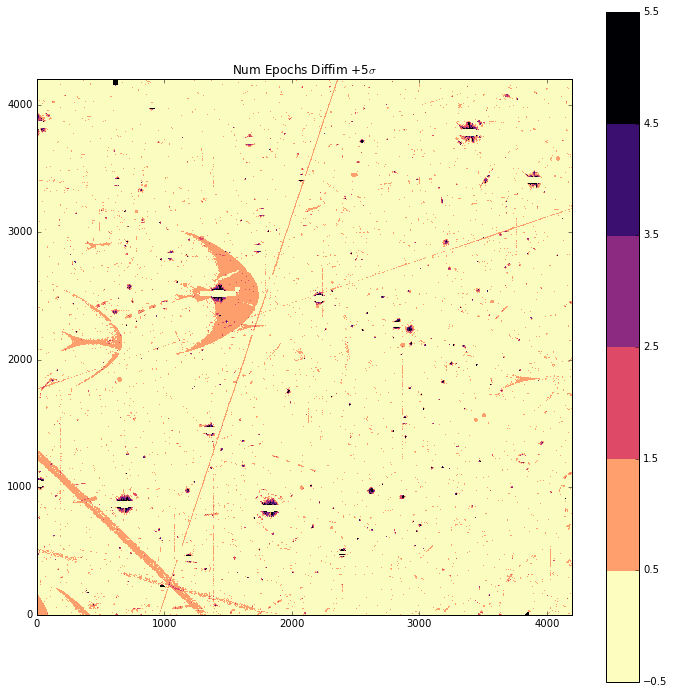

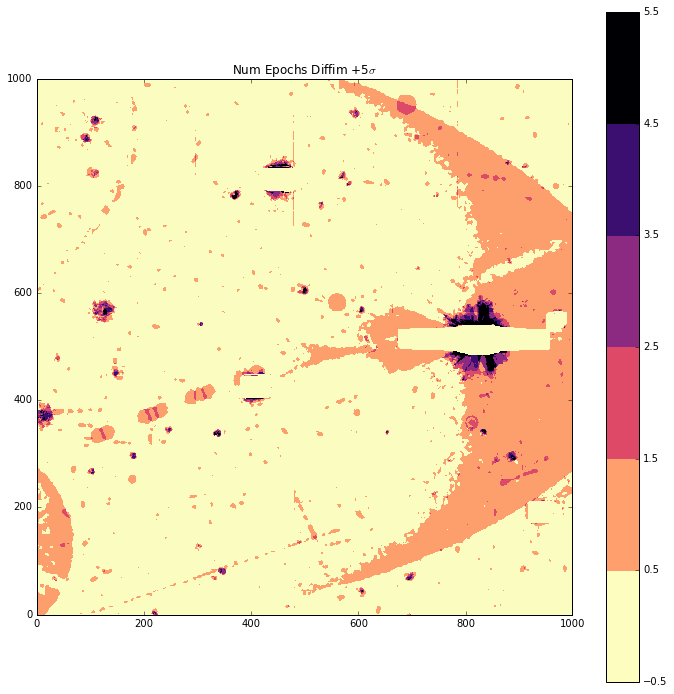

In [15]:
plt.figure(figsize=(12,12))
cmap=plt.cm.magma_r
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,6.5,1), cmap.N)
plt.imshow(sum_count_pos, norm=norm , origin='lower', cmap=cmap, interpolation='nearest')
plt.title("Num Epochs Diffim +5$\sigma$")
plt.colorbar()

plt.figure(figsize=(12,12))
cmap=plt.cm.magma_r
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,6.5,1), cmap.N)
plt.title("Num Epochs Diffim +5$\sigma$")
plt.imshow(sum_count_pos[2000:3000, 600:1600], norm=norm , origin='lower', cmap=cmap, interpolation='nearest')
plt.colorbar()

**Examples of of real transients we want to mask:**

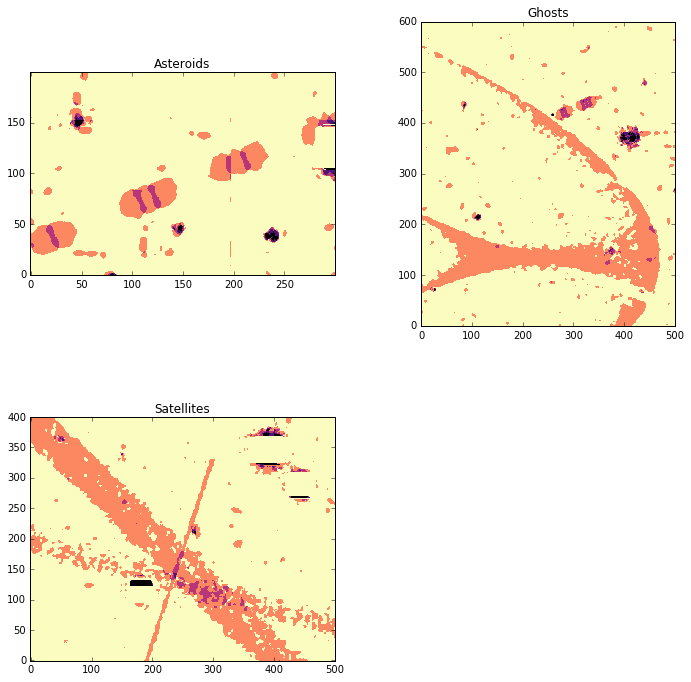

In [16]:
cmap=plt.cm.magma_r
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N)
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(sum_count_pos[2300:2500, 700:1000], norm=norm , origin='lower',
           cmap=cmap, interpolation='nearest')
plt.title("Asteroids")

plt.subplot(222)
plt.imshow(sum_count_pos[2000:2600, 200:700], norm=norm , origin='lower',
           cmap=cmap, interpolation='nearest')
plt.title("Ghosts")

plt.subplot(223)
plt.imshow(sum_count_pos[100:500, 800:1300], norm=norm , origin='lower',
           cmap=cmap, interpolation='nearest')
plt.title("Satellites")



**Examples of poor subtraction artifacts we do not want to mask:**

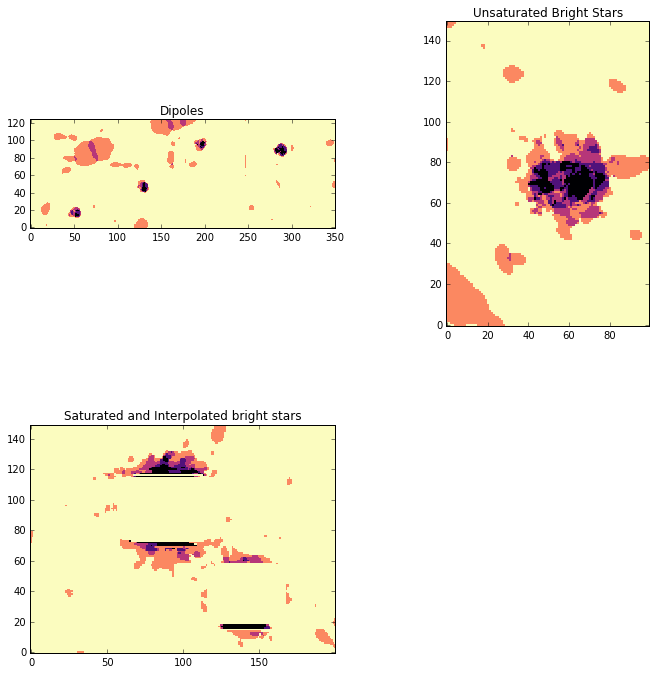

In [17]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(sum_count_pos[2250:2375, 650:1000], norm=norm , origin='lower',
           cmap=cmap, interpolation='nearest')
plt.title("Dipoles")

plt.subplot(222)
plt.imshow(sum_count_pos[2300:2450, 550:650], norm=norm , origin='lower',
           cmap=cmap, interpolation='nearest')
plt.title("Unsaturated Bright Stars")

plt.subplot(223)
plt.imshow(sum_count_pos[350:500, 1100:1300], norm=norm , origin='lower',
           cmap=cmap, interpolation='nearest')
plt.title("Saturated and Interpolated bright stars")


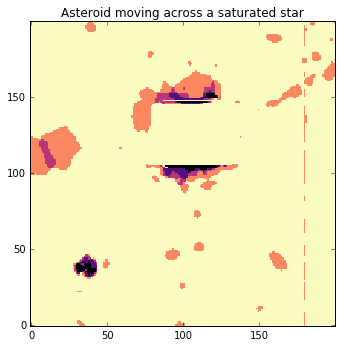

In [18]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(sum_count_pos[2300:2500, 900:1100], norm=norm , origin='lower',
           cmap=cmap, interpolation='nearest')
plt.title("Asteroid moving across a saturated star")


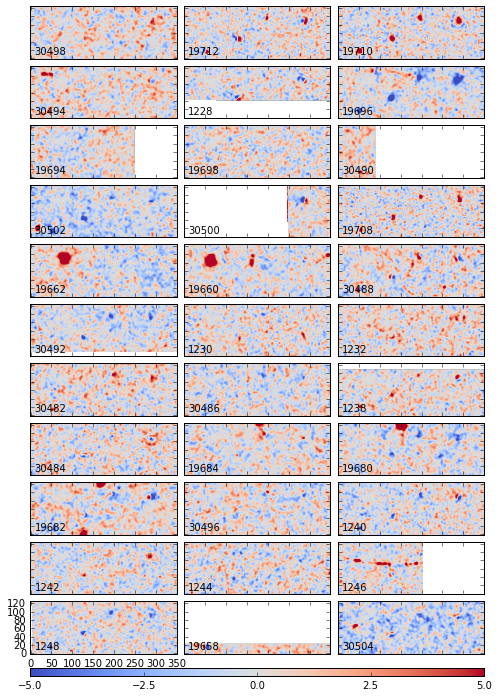

In [19]:
N = len(cubeSNR)
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


fig = plt.figure(1, (12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(N//3, 3), 
                 axes_pad=0.1,
                 label_mode='1', 
                 cbar_mode = 'single',
                 cbar_location="bottom"
                 )

for i in range(N):
    grid[i].text(10,10, keyList[i])
    im = grid[i].imshow(cubeSNR[i,2250:2375, 650:1000], vmin=-5, vmax=5,
                        origin='lower', cmap='coolwarm')

grid.cbar_axes[0].colorbar(im)


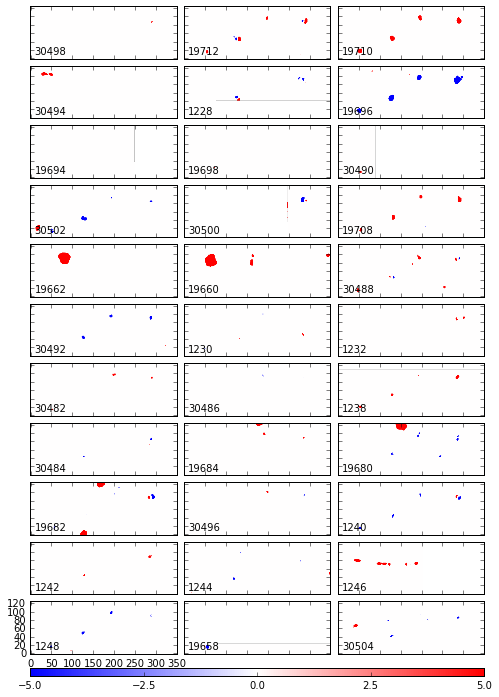

In [20]:
N = len(snr)
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


fig = plt.figure(1, (12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(N//3, 3), 
                 axes_pad=0.1,
                 label_mode='1', 
                 cbar_mode = 'single',
                 cbar_location="bottom"
                 )

for i in range(N):
    grid[i].text(10,10, keyList[i])
    im = grid[i].imshow(snr[i,2250:2375, 650:1000], vmin=-5, vmax=5,
                        origin='lower', cmap='bwr')

grid.cbar_axes[0].colorbar(im)



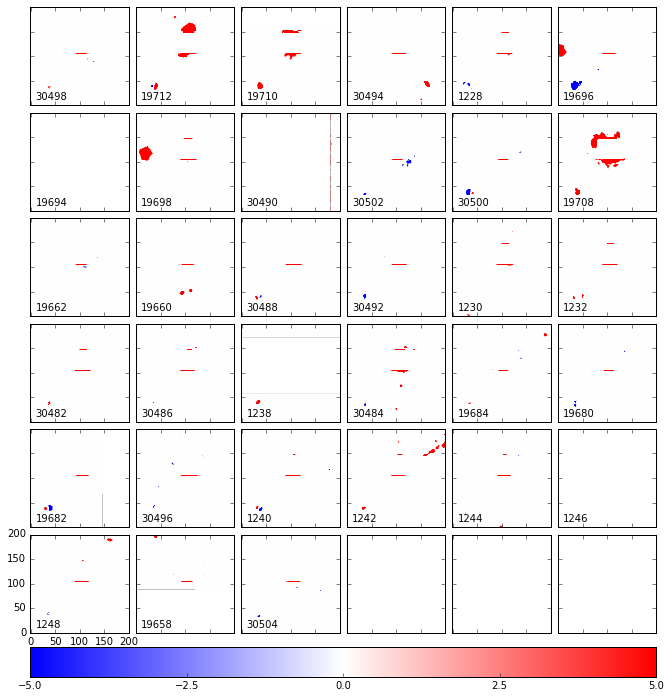

In [21]:
N = len(snr)
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


fig = plt.figure(1, (12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(6,6), 
                 axes_pad=0.1,
                 label_mode='1', 
                 cbar_mode = 'single',
                 cbar_location="bottom"
                 )

for i in range(N):
    grid[i].text(10,10, keyList[i])
    im = grid[i].imshow(snr[i, 2300:2500, 900:1100], vmin=-5, vmax=5,
                        origin='lower', cmap='bwr')

grid.cbar_axes[0].colorbar(im)

# SPACE: Growing detections

In [30]:
import lsst.afw.image as afwImage
import lsst.daf.persistence as dafPersist

visit = 30504
exp = expDict['30504']
im = exp.getMaskedImage().getImage()
mask = exp.getMaskedImage().getMask()
mask.addMaskPlane("CLIPPED")
var = exp.getMaskedImage().getVariance()

snrIm = im.Factory(1./np.sqrt(var.getArray()))
snrIm *= exp.getMaskedImage().getImage()
snrArr = np.copy(snrIm.getArray())




/tigress/HSC/LSST/stack_20160915/Linux64/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/tigress/HSC/LSST/stack_20160915/Linux64/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


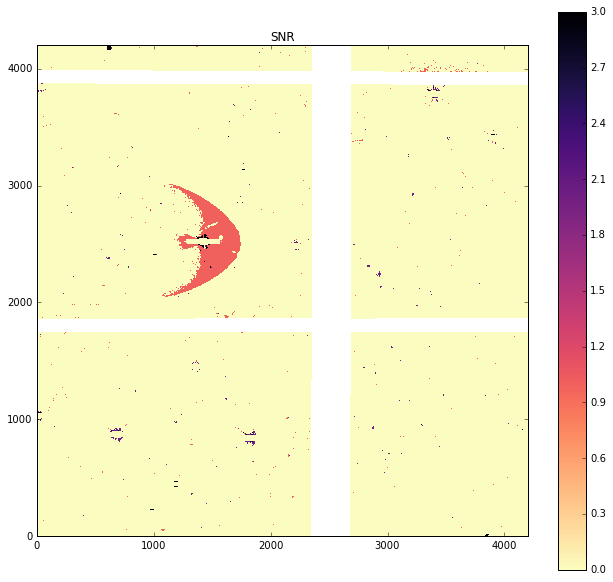

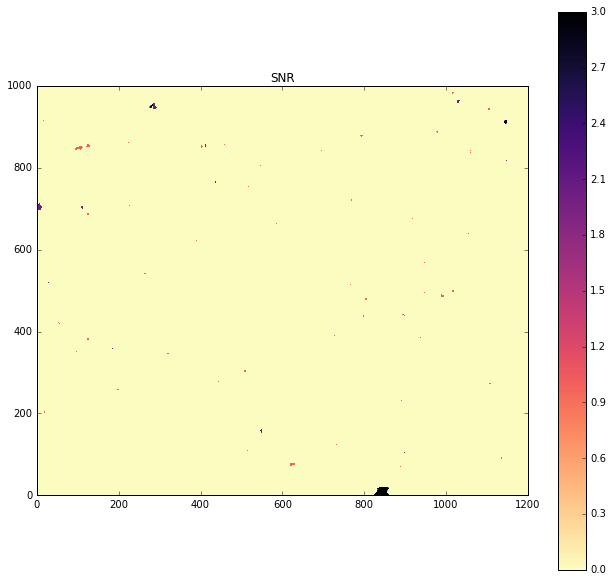

In [23]:
snrArr = np.copy(snrIm.getArray())
snrArr[np.where(snrArr < 4)] = 0
snrArr[np.where(snrArr >= 4)] = 1
snrArr[np.where(sum_count_pos > 3)] = snrArr[np.where(sum_count_pos > 3)] + 2

plt.figure(figsize=(11,10))
plt.imshow(snrArr,  origin='lower', cmap="magma_r", interpolation='nearest')
plt.title('SNR')
plt.colorbar()

plt.figure(figsize=(11,10))
plt.imshow(snrArr[0:1000, 3000:],  origin='lower', cmap="magma_r", interpolation='nearest')
plt.title('SNR')
plt.colorbar()

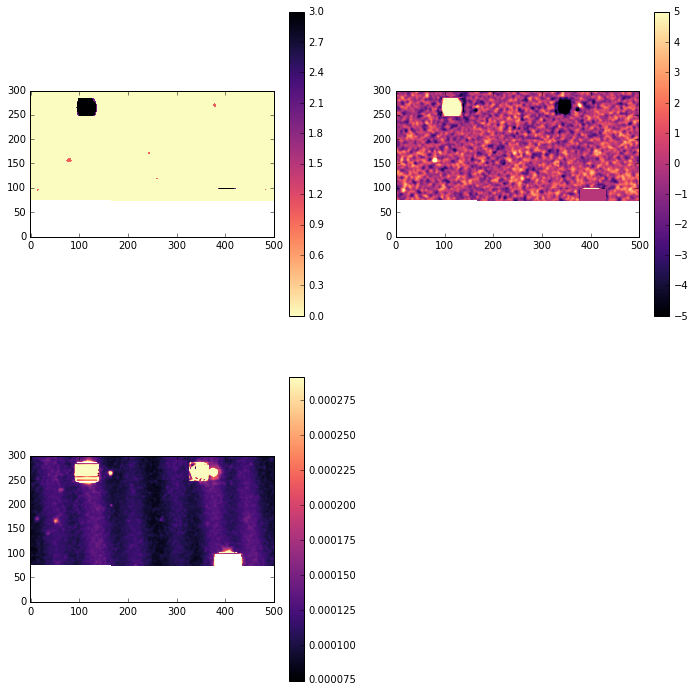

In [24]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(snrArr[3900:, 500:1000],  origin='lower', cmap="magma_r", interpolation='nearest')
plt.colorbar()
plt.subplot(222)
plt.imshow(snrIm.getArray()[3900:, 500:1000], vmin=-5, vmax=5, origin='lower', cmap="magma", interpolation='nearest')
plt.colorbar()
plt.subplot(223)
vmin, vmax = np.percentile(var.getArray()[np.where(np.isfinite(var.getArray()))], [0, 98])
plt.imshow(var.getArray()[3900:, 500:1000], vmin=vmin, vmax=vmax, origin='lower', cmap="magma", interpolation='nearest')

plt.colorbar()

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(exp.getMaskedImage().getImage().getArray()[2000:2400, 600:1000],vmin=-0.07, vmax=0.07, origin='lower', cmap="magma", interpolation='nearest')
plt.title("Dipoles in Diff Image")
plt.colorbar()

In [ ]:

outliers = afwImage.MaskU(snrArr.astype(np.uint16))
newSpans = afwGeom.SpanSet.fromMask(outliers)
maskClip = afwImage.MaskU(outliers.getBBox())
maskClipValue = maskClip.getMaskPlane("CLIPPED")
moreSpans = [s.dilated(13, afwGeom.Stencil.BOX) for s in newSpans.split()]
_ = [span.clippedTo(maskClip.getBBox()).setMask(maskClip, maskClipValue) for span in moreSpans]

In [ ]:
plot(maskClip.getArray() & 2**(maskClip.getMaskPlane("CLIPPED")), "mask", 'Greys')